In [1]:
import random
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import signal
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

def get_s800_time(names):
    return [ 6.25 * float(el.split('_')[1][-2:]) for el in names]

def get_periodgram(sc_data):
    return [signal.periodogram(sc_data.X[:,i]) for i in range(sc_data.shape[1])]

def plot_one_row_line(df, row_num):
    df.iloc[row_num,:].plot.line()
    
def plot_one_row_scatter(df, row_num, time):
    plt.scatter(df.iloc[row_num,:], time)
    
def dist(x, y):
    # TODO normed difference
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    
    return (x-y).T@(x-y)


"""
    this implementation of k-means takes as input (i) a matrix pd
    with the data points as rows (ii) an integer K representing the number 
    of clusters, and returns (i) a matrix with the K rows representing 
    the cluster centers 
    """
def k_means_from_pd_data(pd, K, maxIters = 300):
   
    centroids = pd[np.random.choice(pd.shape[0], K, replace=False)]
    old_centroids = centroids.copy()
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([dist(x_i, y_k) for y_k in centroids]) for x_i in pd])
        # Update centroids step
        for k in range(K):
            if (C == k).any():                
                centroids[k] = pd[C == k].mean(axis = 0) 
            else: # if there are no data points assigned to this certain centroid
                centroids[k] = pd[np.random.choice(len(pd))] 
        if np.array_equal(centroids, old_centroids):
            print(f'converged on iter: {i}')
            break
        old_centroids = centroids.copy()
    return C, centroids

def add_top_n_expressed_label_to_var(data,top_n):
    cutoff = sorted(data.var.n_counts, reverse=True)[top_n]

    for i in range(0, data.var.shape[0]):
        if data.var.iloc[i,:].n_counts > cutoff:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = True
        else:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = False
    


In [4]:

s814_adata = sc.read("data/sub_0814_miRNA.ec.tab").T

s814_adata.obs['time'] = get_s814_time(s814_adata.obs.index)

sc.pp.normalize_total(s814_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s814_adata)
sc.pp.filter_genes(s814_adata, min_counts=1)


add_top_n_expressed_label_to_var(s814_adata,50)
#print(s814_adata[:,1:3])
#print(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])])
#print(type(s814_adata.var.top_n_expressed))

#sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )
s814_pd = get_periodgram(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])]) 
s814_pd_array = np.array([i[1] for i in s814_pd])
print(s814_pd_array[25])
print(len(s814_pd))

[2.4641622e-11 3.4812543e-01 1.3989905e-01 7.8009218e-02 6.5219678e-02
 9.0177983e-02 3.1848498e-02 2.7372014e-02 1.9688524e-02 3.7905838e-02
 1.4061682e-02 1.7347996e-01 9.2230886e-01 2.3806987e-02 4.5655709e-02
 1.5711252e-02 4.6952250e-03 6.0983766e-03 1.0231419e-02 2.5940535e-03
 2.1742996e-02 4.6457358e-02 1.9747389e-03 5.4919045e-02 1.7456084e-01
 7.5486898e-02 3.0267786e-02 1.3044531e-02 2.5736859e-02 2.4571461e-03
 5.3946566e-02 6.3103990e-04 5.8050342e-03 6.5464668e-02 2.6516749e-02
 6.1991431e-02 2.2188187e-01 1.7549794e-02 3.0905267e-03 4.7858216e-02
 5.1911902e-03 4.0750054e-04 5.9236597e-02 2.9316120e-02 7.2969362e-02
 3.8458928e-02 5.3980596e-02 6.7686990e-02 1.5694583e-03]
50


In [5]:
K = 6
C, centroids = k_means_from_pd_data(s814_pd_array,K)

print('C = \n', C)

converged on iter: 5
C = 
 [0 2 2 2 2 5 1 4 2 2 2 0 0 2 5 1 3 2 0 1 1 0 0 2 2 5 5 1 5 1 2 5 1 2 2 0 5
 2 5 2 2 5 2 5 3 2 2 0 1 0]


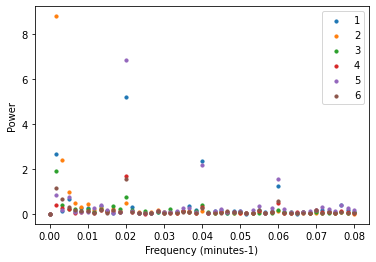

0.01

In [4]:

#matplotlib.pyplot.scatter(s814_pd[0][0],centroids_2[1])
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s814_pd[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )


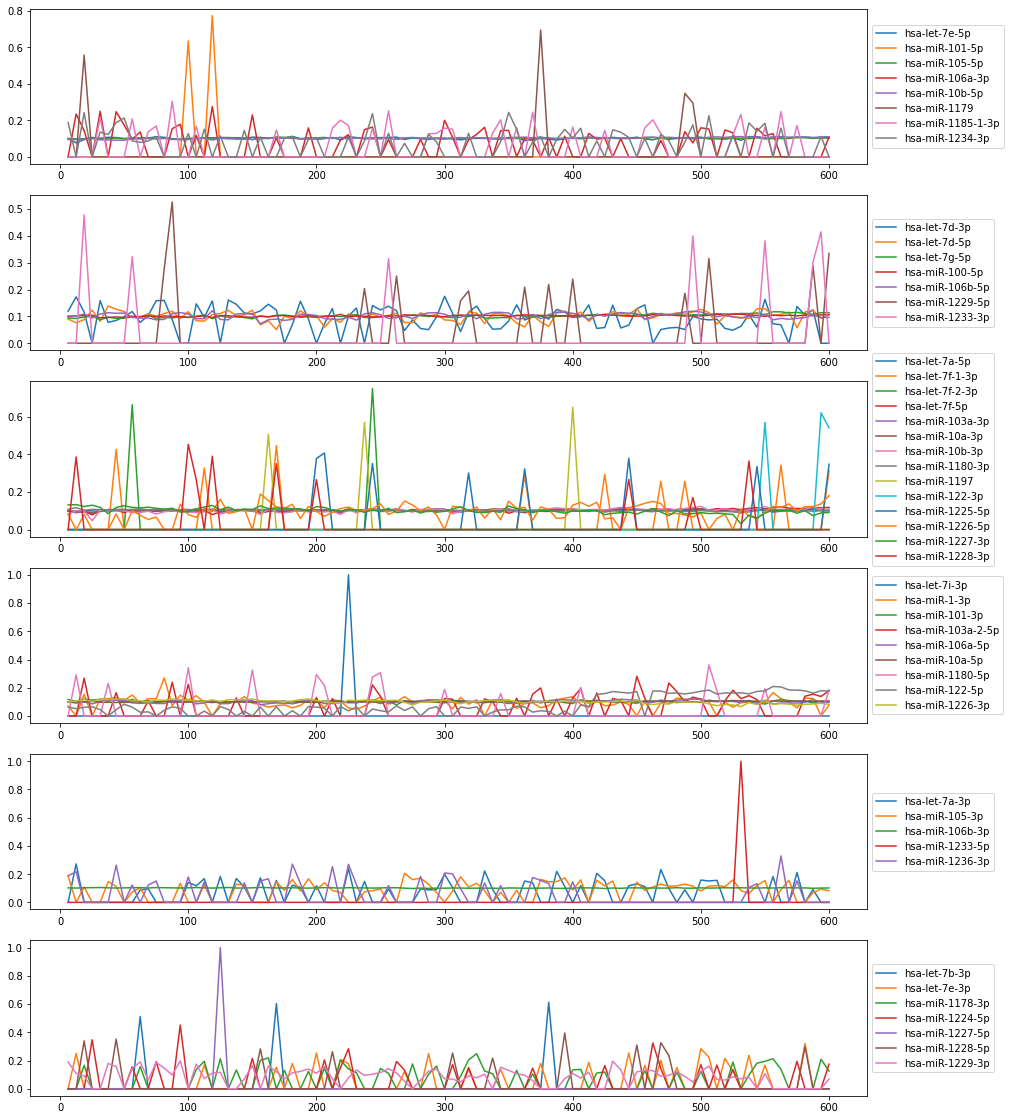

In [5]:

fig, axs = plt.subplots(K,1, figsize=(15,20))

time = s814_adata.obs.time

for i_k in range(K):
    for i in range(len(C)):
        if C[i]==i_k:
            y = s814_adata.X[:,i]
            axs[i_k].plot(time,y/np.linalg.norm(y), label=s814_adata.var.index[i].split(',')[0])
            axs[i_k].legend(loc='center left', bbox_to_anchor=(1, 0.5))
   
#plt.ylabel('Power')

#plt.legend();
#plt.show();

#for i in range(10):
   # matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

In [9]:
s800_adata = sc.read("data/s800.tab").T

s800_adata.obs['time'] = get_s800_time(s800_adata.obs.index)

sc.pp.normalize_total(s800_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s800_adata)
sc.pp.filter_genes(s800_adata, min_counts=1)


add_top_n_expressed_label_to_var(s800_adata,200)
#print(s814_adata[:,1:3])
#print(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])])
#print(type(s814_adata.var.top_n_expressed))

#sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )
s800_pd = get_periodgram(s800_adata[:,s800_adata.var.top_n_expressed.isin([True])]) 
s800_pd_array = np.array([i[1] for i in s800_pd])
print(len(s800_pd))


200


In [26]:
# Find the cluster which has 10-5p guy.
# for each gene in s800_pd, find the distance from pd_gene_i, sort, pick 20 closest.
position_of_10a_5p = list(s814_adata.var.index).index('hsa-miR-10a-5p')
# index in anndata.var means gene names
# but list data type also has a function, called index(), which returns position
Centroid_label_with_10a_5p = C[position_of_10a_5p]
Centroid_values_for_10a_5p = centroids[Centroid_label_with_10a_5p]
print(position_of_10a_5p)
#print( Centroid_values_for_10a_5p )
#s800.var['dist_to_10a_5p_cluster'] = ... 

s800_top = s800_adata[:,s800_adata.var.top_n_expressed.isin([True])]
for i in range(len(s800_pd)):
    s800_adata.var.loc[s800_top.var.index[i], 'dist'] = dist(s814_pd_array[25],s800_pd_array[i])

#print(s800_adata.var.dist)
cutoff = sorted(s800_top.var.dist, reverse=False)[20]
s800_20 = s800_top[:,s800_top.var.dist < cutoff]
print(s800_20.var)


25
           n_counts top_n_expressed      dist
CCDC72   637.835449            True  0.141241
CCT8     651.822876            True  0.156738
CSDE1    663.356384            True  0.192988
EIF3E    676.784058            True  0.194499
EIF4B    637.730835            True  0.205452
EIF4G2   642.373474            True  0.213293
LDHB     784.871704            True  0.175337
MORF4L1  640.215271            True  0.122823
NTS      665.331787            True  0.131670
PDIA3    644.784058            True  0.146619
RCN1     668.600830            True  0.218616
RPL23    846.047424            True  0.198522
RPL7     776.598572            True  0.151047
RPS21    668.112122            True  0.222344
SCD      702.716492            True  0.133659
SEC11A   693.345276            True  0.131854
TPT1     807.593750            True  0.179618
TUBA1A   707.114197            True  0.132328
TUBA1B   760.434814            True  0.186520
YWHAZ    706.308472            True  0.185521


In [27]:

s745_adata = sc.read("data/sub_0745_miRNA.ec.tab").T

s745_adata.obs['time'] = get_s745_time(s745_adata.obs.index)

sc.pp.normalize_total(s745_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s745_adata)
sc.pp.filter_genes(s745_adata, min_counts=1)


add_top_n_expressed_label_to_var(s745_adata,50)
#print(s814_adata[:,1:3])
#print(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])])
#print(type(s814_adata.var.top_n_expressed))

#sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )
s745_pd = get_periodgram(s745_adata[:,s745_adata.var.top_n_expressed.isin([True])]) 
s745_pd_array = np.array([i[1] for i in s745_pd])
print(s745_pd_array[25])
print(len(s745_pd))

[2.72848411e-12 1.86872749e+01 1.90054893e+00 6.30396843e-01
 1.87623870e+00 4.55230653e-01 6.56636477e-01 1.22142506e+00
 2.63690613e-02 1.20662868e-01 2.10645460e-02 4.54425305e-01
 5.89721620e-01 9.15445566e-01 4.74727631e-01 2.62323201e-01
 1.48979098e-01 3.24083805e-01 2.08587915e-01 4.99433994e-01
 9.63712260e-02 4.74385172e-02 9.59031209e-02 9.87433344e-02
 1.96423858e-01 2.23730989e-02 7.93502182e-02 1.06912605e-01
 1.93903729e-01 1.14491515e-01 7.85521115e-04 1.04691207e-01
 1.80472225e-01 5.30206077e-02 3.29088271e-02 1.36700258e-01
 1.71210617e-02 2.72959113e-01 7.33343959e-02 1.21079877e-01
 1.32620052e-01 1.53889924e-01 2.06135750e-01 8.99571329e-02
 3.80154848e-02 2.06140466e-02 3.77761945e-02 2.19916984e-01
 6.14916325e-01 6.82497770e-02 2.92553008e-02 5.64311147e-02
 1.18165478e-01 2.93546394e-02 2.37958372e-01 3.02924484e-01
 7.29947910e-02 5.47149442e-02 3.98282290e-01 1.14792138e-01
 4.89060372e-01 3.54257226e-01 3.58849391e-02 3.34239006e-02
 1.21711120e-01 2.042407

In [29]:
K = 6
C, centroids = k_means_from_pd_data(s745_pd_array,K)

print('C = \n', C)

converged on iter: 4
C = 
 [2 4 4 5 5 3 2 4 5 5 0 4 1 5 1 4 2 5 1 4 4 4 5 1 0 3 1 3 4 5 3 4 0 0 5 0 2
 3 5 5 3 2 4 1 2 2 0 5 1 1]


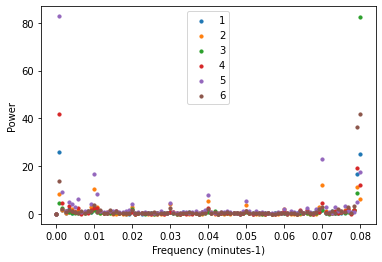

0.01

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s745_pd[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )



In [32]:
s743_adata = sc.read("data/s743.tab").T

s800_adata.obs['time'] = get_s800_time(s800_adata.obs.index)

sc.pp.normalize_total(s800_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s800_adata)
sc.pp.filter_genes(s800_adata, min_counts=1)


add_top_n_expressed_label_to_var(s800_adata,200)
#print(s814_adata[:,1:3])
#print(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])])
#print(type(s814_adata.var.top_n_expressed))

#sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )
s800_pd = get_periodgram(s800_adata[:,s800_adata.var.top_n_expressed.isin([True])]) 
s800_pd_array = np.array([i[1] for i in s800_pd])
print(len(s800_pd))



FileNotFoundError: Did not find file data/s743.tab.

In [ ]:
position_of_10a_5p = list(s745_adata.var.index).index('hsa-miR-10a-5p')
# index in anndata.var means gene names
# but list data type also has a function, called index(), which returns position
Centroid_label_with_10a_5p = C[position_of_10a_5p]
Centroid_values_for_10a_5p = centroids[Centroid_label_with_10a_5p]

#print( Centroid_values_for_10a_5p )
#s800.var['dist_to_10a_5p_cluster'] = ... 

s800_top = s800_adata[:,s800_adata.var.top_n_expressed.isin([True])]
for i in range(len(s800_pd)):
    s800_adata.var.loc[s800_top.var.index[i], 'dist'] = dist(
        s745_pd_array[position_of_10a_5p],s800_pd_array[i]
    )

#print(s800_adata.var.dist)
cutoff = sorted(s800_top.var.dist, reverse=False)[20]
s800_20 = s800_top[:,s800_top.var.dist < cutoff]
print(s800_20.var)


